In [51]:
import onnx
import onnxruntime
from torchvision.io import read_image
from torchvision.transforms import transforms
import numpy as np

In [52]:
img = read_image("../QR_d_best/1_1_A_12.jpg")
img = img.float()
img = img / 255.0
transform = transforms.Resize((64, 64))
img = transform(img)
img = img.unsqueeze(0)
img.shape

torch.Size([1, 1, 64, 64])

In [53]:
img = img.numpy()
img.shape
img.astype(np.float16)
# type(a)

array([[[[0.753 , 0.745 , 0.745 , ..., 0.8823, 0.8667, 0.8394],
         [0.7373, 0.757 , 0.741 , ..., 0.886 , 0.8784, 0.8784],
         [0.745 , 0.7646, 0.7373, ..., 0.9253, 0.906 , 0.906 ],
         ...,
         [0.745 , 0.749 , 0.749 , ..., 0.749 , 0.7334, 0.757 ],
         [0.753 , 0.745 , 0.745 , ..., 0.796 , 0.749 , 0.749 ],
         [0.749 , 0.749 , 0.749 , ..., 0.784 , 0.749 , 0.749 ]]]],
      dtype=float16)

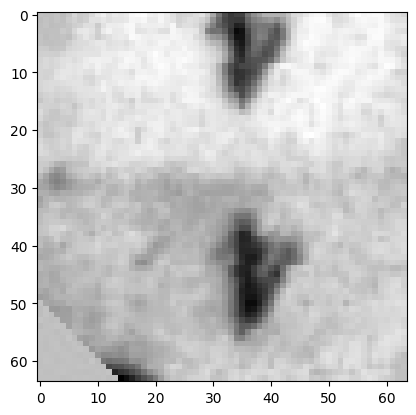

In [21]:
import matplotlib.pyplot as plt

plt.imshow(img.squeeze(0, 1), cmap="gray")
plt.show()

In [48]:
img = np.repeat(img, 10, axis=0) 

In [54]:
ort_session = onnxruntime.InferenceSession("model.onnx")
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: img}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs)
""" input_info = ort_session.get_inputs()[0]
print("Input name:", input_info.name)
print("Input shape:", input_info.shape)
print("Input type:", input_info.type) """

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input.1 for the following indices
 index: 0 Got: 1 Expected: 10
 Please fix either the inputs/outputs or the model.

In [61]:
import lightning as L
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F

In [62]:
class Net(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.conv1 = nn.Conv2d(1, 32, 7)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.conv4 = nn.Conv2d(128, 256, 3)
        
        x = torch.randn((1, 64, 64))
        self._to_linear = None
        
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, 4)
        
        self.loss_function = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy('multiclass', num_classes=4)
        self.f1_score = torchmetrics.F1Score('multiclass', num_classes=4)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        if self._to_linear is None:
            self._to_linear = x.shape[0] * x.shape[1] * x.shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    
    def _common_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), 1, 64, 64)
        output = self.forward(x)
        loss = self.loss_function(output, y)
        preds = torch.argmax(output, dim=1)
        return loss, preds, y
    
    def training_step(self, batch, batch_idx):
        loss, preds, y = self._common_step(batch, batch_idx)
        y = torch.argmax(y, dim=1)
        train_accuracy = self.accuracy(preds, y)
        train_f1_score = self.f1_score(preds, y)
        self.log_dict({'train_loss': loss, 'train_accuracy': train_accuracy, 'train_f1_score': train_f1_score},
                      prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, preds, y = self._common_step(batch, batch_idx)
        y = torch.argmax(y, dim=1)
        val_accuracy = self.accuracy(preds, y)
        val_f1_score = self.f1_score(preds, y)
        self.log_dict({"val_loss": loss, "val_accuracy": val_accuracy, "val_f1_score": val_f1_score},
                      prog_bar=True, on_epoch=True, on_step=False)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, scores, y = self._common_step(batch, batch_idx)
        self.log('test_loss', loss)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), 1, 64, 64)
        scores = self.forward(x)
        preds = torch.argmax(scores, dim=1)
        return preds
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)
        

In [65]:
model = Net.load_from_checkpoint("checkpoint/QR_d_best-epoch=epoch=14-val_loss+val_loss=0.01.ckpt", map_location=torch.device("cuda"))

In [66]:
import torch.onnx

In [67]:
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (loss_function): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
  (f1_score): MulticlassF1Score()
)

In [89]:
example_input = torch.randn(1, 1, 64, 64).to("cuda")

In [90]:
torch.onnx.export(model, example_input, "model2.onnx", input_names=['input'], 
                  output_names=['output'])

In [91]:
img = read_image("../QR_d_best/1_1_A_12.jpg")
img = img.float()
img = img / 255.0
transform = transforms.Resize((64, 64))
img = transform(img)
img = img.unsqueeze(0)
img.shape

torch.Size([1, 1, 64, 64])

In [92]:
img = img.numpy()
img.shape
img.astype(np.float16)
# type(a)

array([[[[0.753 , 0.745 , 0.745 , ..., 0.8823, 0.8667, 0.8394],
         [0.7373, 0.757 , 0.741 , ..., 0.886 , 0.8784, 0.8784],
         [0.745 , 0.7646, 0.7373, ..., 0.9253, 0.906 , 0.906 ],
         ...,
         [0.745 , 0.749 , 0.749 , ..., 0.749 , 0.7334, 0.757 ],
         [0.753 , 0.745 , 0.745 , ..., 0.796 , 0.749 , 0.749 ],
         [0.749 , 0.749 , 0.749 , ..., 0.784 , 0.749 , 0.749 ]]]],
      dtype=float16)

In [93]:
ort_session = onnxruntime.InferenceSession("model2.onnx")
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: img}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs)

[array([[-2.2631612, -3.3856773, -3.914068 ,  5.0591774]], dtype=float32)]
